In [1]:
import fastf1
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from shapely.geometry import LineString
import math
from shapely.affinity import translate
import matplotlib.pyplot as plt

import os
import imageio.v2 as imageio
import re

session = fastf1.get_session(2023, 'Monza', 'R')

req         WARNING 	DEFAULT CACHE ENABLED! (695.49 MB) /Users/flo/Library/Caches/fastf1


In [2]:
session.load(telemetry=True, laps=True, weather=False)

core           INFO 	Loading data for Italian Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '44', '23', '4', '14', '77', '40', '81', '2', '24', '10', '18', '27', '20', '31', '22']


In [3]:
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [4]:
laps = session.laps
drivers = session.drivers
circuit_info = session.get_circuit_info()
corners_df = circuit_info.corners
lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

### Finding the corners

In [5]:
track = pd.DataFrame(pos.loc[:, ('X', 'Y')].to_numpy())

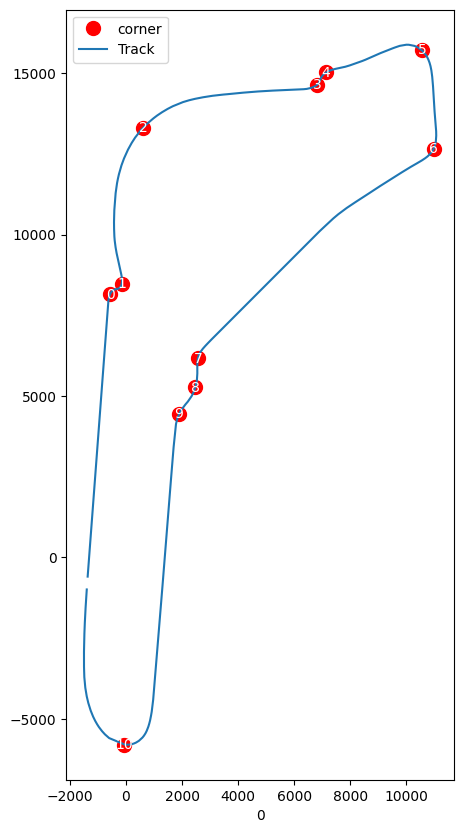

In [6]:
ax = corners_df.plot('X','Y',style = 'o',color = 'red',ms = 10,label = 'corner',figsize = (5,10))
for i, txt in enumerate(corners_df.index):
    ax.annotate(txt, (corners_df['X'][i], corners_df['Y'][i]),ha = 'center', va = 'center',color = 'white')
track.plot(x=0, y=1, ax=ax,label = 'Track');


In [7]:
for i in range(len(corners_df)):
    corner_x = corners_df.iloc[i]['X']
    corner_y = corners_df.iloc[i]['Y']
    
    pos[f'Distance_to_Corner_{i}'] = euclidean_distance(pos['X'], pos['Y'], corner_x, corner_y)
    
    if i == corners_df.index[-1]:
        within_threshold = pos[f'Distance_to_Corner_{i}'] < 2000
    else:
        within_threshold = pos[f'Distance_to_Corner_{i}'] < 500

    
    pos.loc[within_threshold, 'Corner_Number'] = int(i)

pos = pos.dropna().drop(columns=[f'Distance_to_Corner_{i}' for i in range(len(corners_df))])

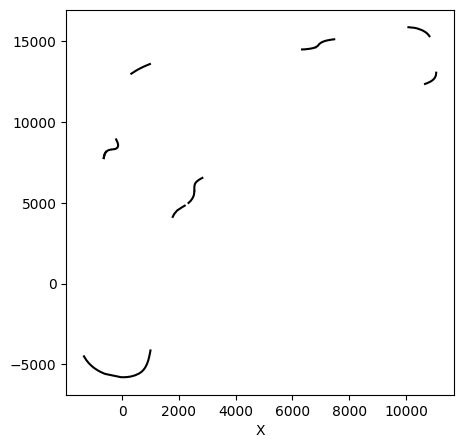

In [8]:
ax = pos[pos['Corner_Number'] == 0].plot(x='X', y='Y', figsize=(5, 5),legend = False,color = 'black')
def plot_multiple(driver):
    pos[pos['Corner_Number'] == driver ].plot(x = 'X', y = 'Y', ax=ax, label = f'Corner {driver}',figsize = (5,5),legend = False,color = 'black');
for i in list(set(pos['Corner_Number'].dropna())):
    plot_multiple(i)

### Getting all laps

In [9]:
telemetry_data = dict()

for driver in drivers:
    driver_telemetry = []
    try:
        driver_laps = laps.pick_driver(driver)
        for lap in driver_laps.iterlaps():
            telemetry = lap[1].get_telemetry()
            telemetry['LapNumber'] = lap[1]['LapNumber']
            driver_telemetry.append(telemetry)
        telemetry_data[driver] = pd.concat(driver_telemetry, ignore_index=True)
    except Exception as e:
        print(f"Error processing driver {driver}: {e}")

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

In [10]:
modified_dfs = []

for key, df in telemetry_data.items():
    df['driver'] = key
    modified_dfs.append(df)

concatenated_df = pd.concat(telemetry_data)

concatenated_df.reset_index(drop=True, inplace=True)
concatenated_df['LapNumber'] = concatenated_df['LapNumber'].astype(int)

In [ ]:
concatenated_df = concatenated_df[~concatenated_df['LapNumber'].isin([51,52])]

In [ ]:
concatenated_df = concatenated_df[(concatenated_df['Source'] == 'car') & (concatenated_df['Status'] == 'OnTrack')]

In [ ]:
df_interpolated = []
for index,row in concatenated_df.iterrows():
    df_interpolated.append([row['LapNumber'],row['driver'],row['X'],row['Y'],row['Speed'],row['RPM'],row['nGear'], row['Throttle'],row['Brake']])
    for i in range(15):
        df_interpolated.append([row['LapNumber'],row['driver'],np.nan,np.nan,np.nan,np.nan,row['nGear'],row['Throttle'],row['Brake']])

In [ ]:
df_interpolated = pd.DataFrame(df_interpolated,columns = ['LapNumber','driver','X','Y','Speed','RPM','nGear','Throttle','Brake'])

In [ ]:
df_interpolated['X'] = df_interpolated['X'].interpolate(method='linear')
df_interpolated['Y'] = df_interpolated['Y'].interpolate(method='linear')
df_interpolated['Speed'] = df_interpolated['Speed'].interpolate(method='linear')
df_interpolated['RPM'] = df_interpolated['RPM'].interpolate(method='linear')

In [ ]:
df_interpolated['Distance_to_corner'] = np.sqrt((df_interpolated['X'] - corners_df['X'].iloc[1]) ** 2 + (df_interpolated['Y'] - corners_df['Y'].iloc[1]) ** 2)

threshold_distance = 1000

filtered_df = df_interpolated[df_interpolated['Distance_to_corner'] < threshold_distance]

### Plots

In [ ]:
drivers = set(df_interpolated['driver'])
laps = set(df_interpolated['LapNumber'])

In [ ]:
def plot_all_drivers_for_lap(plot_test, lap):
    plt.figure(figsize=(10, 14))
    for driver in drivers:
        data = plot_test[(plot_test['driver'] == driver) & (plot_test['LapNumber'] == lap)]
        plt.plot(data['X'], data['Y'], label=f'Driver {driver}', linewidth=0.1,color = 'black')
    plt.title(f'Lap {lap} - All Drivers')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'img/{lap}Lap.png')
    plt.close()

for lap in laps:
    plot_all_drivers_for_lap(df_interpolated, lap)

In [ ]:
def plot_all_laps_all_drivers(plot_test):
    plt.figure(figsize=(10, 14),dpi=500)
    for lap in laps:
            for driver in drivers:
                data = plot_test[(plot_test['driver'] == driver) & (plot_test['LapNumber'] == lap)]
                plt.plot(data['X'], data['Y'], label=f'Lap{lap}, Driver {driver}', linewidth=0.1,color = 'black')
    plt.title('All Laps - All Drivers')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('img/all/AllLaps_AllDrivers.png')
    plt.close()

plot_all_laps_all_drivers(df_interpolated)

In [ ]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def create_gif(image_folder, gif_name):
    images = []
    for filename in sorted(os.listdir(image_folder),key = natural_sort_key):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            images.append(imageio.imread(os.path.join(image_folder, filename)))
    imageio.mimsave(gif_name, images, duration=500)  # Adjust duration as needed

image_folder = 'img'
gif_name = 'output.gif'

create_gif(image_folder, gif_name)

### Loading the Monza Track

In [ ]:
# Load the GeoDataFrame
monza_track = gpd.read_file("bacinger f1-circuits master circuits/it-1922.geojson") #This is monza
centroid = monza_track.geometry.centroid.iloc[0]
monza_track_projected = monza_track.to_crs(epsg=32632)

# Process the geometry to add width by buffering (buffer distance in meters)
width_in_meters = 5
monza_track_buffered = monza_track_projected.copy(deep = True)
monza_track_buffered['geometry'] = monza_track_buffered.geometry.buffer(width_in_meters)

In [ ]:
def coordinate_shift(original_centroid, f1_api_coords):
    """This translates the original relative coordinates into longitude and latitude
    original_centroid is the centroid computed from the downloaded track data
    """
    centroid_lon, centroid_lat = (original_centroid.x, original_centroid.y)  


      
    # conversion factors - these are approximations, adjust as necessary  
    # 1 degree of latitude is approximately 111 km, and 1 degree of longitude is approximately 111 km multiplied by the cosine of the latitude  
    km_per_degree_lat = 1 / 111  
    km_per_degree_lon = 1 / (111 * math.cos(math.radians(centroid_lat)))  
    
    # your array of tuples  
    xy_coordinates = f1_api_coords
    
    # convert each tuple in the array  
    lonlat_coordinates = []  
    for y,x in xy_coordinates:  
        lon = centroid_lon + (x / 10000) * km_per_degree_lon  # assuming x, y are in meters  
        lat = centroid_lat + (y / 10000) * km_per_degree_lat  # assuming x, y are in meters  
        lonlat_coordinates.append((lon,lat))  
    


    relative_line = LineString(lonlat_coordinates)
    return relative_line



def shift_centroid(relative_line,original_centroid):
    """This shift the centroid computed"""
    # Calculate the distance to translate in each direction  
    dx = original_centroid.x - relative_line.centroid.x  
    dy = original_centroid.y - relative_line.centroid.y  
    # dx = -0.004080352801855369
    # dy = -0.0063870841787121435
    # Shift the LineString  
    shifted_line = translate(relative_line, xoff=dx, yoff=dy)  
    return shifted_line

### Similarity and Clustering

In [ ]:
gdf = gpd.GeoDataFrame(df_interpolated, geometry=gpd.points_from_xy(df_interpolated['X'], df_interpolated['Y'])).reset_index(drop=True)

In [ ]:
def distance_func(driver1, driver2,df,lapnumber):
    dist = []
    driver1_geometries = pd.DataFrame(df[(df['driver'] == driver1) & (df['LapNumber'] == lapnumber)]['geometry']).sort_values(by = 'geometry')
    driver2_geometries = pd.DataFrame(df[(df['driver'] == driver2) & (df['LapNumber'] == lapnumber)]['geometry']).sort_values(by = 'geometry')
    
    for i in driver1_geometries['geometry']:
        for j in driver2_geometries['geometry']:
            distance = i.distance(j)
            if distance < 100:
                dist.append(distance)
            else:
                break  
    if dist:
        mean_distance = np.mean(dist)
    else:
        mean_distance = float('inf')  
    
    return mean_distance

In [ ]:
distances = {}
inner_dict = {}
for lap in laps:
       for i in drivers:
              for j in drivers:
                     if i != j:
                            distances[(lap,i,j)] = distance_func(i,j,gdf,lap)

In [ ]:
distance_df = pd.DataFrame(distances.items(), columns = ['driver-pairs', 'distance'])

In [ ]:
distance_df.to_csv('distances.csv',index = False)

In [ ]:
# distance_df = pd.read_csv('distances.csv')

In [ ]:
def str_to_tuple(s):
    s = s.strip('()')
    elements = s.split(', ')
    if len(elements) == 3:
        lap = int(elements[0])
        driver1 = elements[1].strip("'")
        driver2 = elements[2].strip("'")
        return (lap, driver1, driver2)
    else:
        return (None, None, None)

In [ ]:
# distance_df['driver-pairs'] = distance_df['driver-pairs'].apply(str_to_tuple)

In [ ]:
distance_df[['lap', 'driver1', 'driver2']] = pd.DataFrame(distance_df['driver-pairs'].tolist(), index=distance_df.index)

In [ ]:
distance_df = distance_df.groupby(['driver1','driver2']).agg({'distance':'mean'}).reset_index()

In [ ]:
distance_df = distance_df.sort_values(by='distance')

In [ ]:
set_drivers = set()
clusters = []
for index, row in distance_df.iterrows():
    driver1 = row['driver1']
    driver2 = row['driver2']
    if driver1 not in set_drivers and driver2 not in set_drivers:
        clusters.append((driver1, driver2))
        set_drivers.add(driver1)
        set_drivers.add(driver2)

# Convert clusters to a DataFrame (if needed)
clusters_df = pd.DataFrame(clusters, columns=['Driver 1', 'Driver 2'])
clusters_df = clusters_df.reset_index()
clusters_df.rename(columns = {'index':'Cluster'}, inplace = True)

In [ ]:
df_melted = clusters_df.melt(id_vars=['Cluster'], value_vars=['Driver 1', 'Driver 2'], var_name='driver_type', value_name='driver')

In [ ]:
gdf = gdf.merge(df_melted, on = 'driver',how = 'inner')

In [ ]:
gdf.drop(columns = ['driver_type'],inplace = True)

### Driver Correlations

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 14))

gdf.plot(column='Speed', legend=True, figsize=(10, 14), cmap='OrRd',markersize = 0.1,alpha = 0.1,ax = axes[0])
axes[0].set_title('Speed')
axes[0].grid(True)

gdf.plot(column='Throttle', legend=True, figsize=(10, 14), cmap='OrRd',markersize = 0.1,alpha = 0.1,ax = axes[1])
axes[1].set_title('Throttle')
axes[1].grid(True)

gdf.plot(column='Brake', legend=True, figsize=(8, 12), cmap='OrRd',markersize = 0.1,alpha = 0.1,ax = axes[2])
axes[2].set_title('Brake Points')
axes[2].grid(True)

gdf.plot(column='nGear', legend=True, figsize=(10, 14), cmap='OrRd',markersize = 0.1,alpha = 0.1,ax = axes[3])
axes[3].set_title('Gear')
axes[3].grid(True)
plt.tight_layout()
plt.show();


In [ ]:
def corr_func(driver1, driver2,df,lapnumber,col):
    driver1_df = gpd.GeoDataFrame(df[(df['driver'] == driver1) & (df['LapNumber'] == lapnumber)])[['geometry',col]]
    driver2_df = gpd.GeoDataFrame(df[(df['driver'] == driver2) & (df['LapNumber'] == lapnumber)])[['geometry',col]]
    
    corr = driver1_df.sjoin_nearest(driver2_df, distance_col='distance', max_distance=10)

    corr = corr[[f'{col}_left',f'{col}_right']].corr()[f'{col}_right'].iloc[0] 
    
    return corr

In [ ]:
correlations = {}
for lap in laps:
       for i,j in zip(clusters_df['Driver 1'],clusters_df['Driver 2']):
              correlations[(lap,i,j)] = corr_func(i,j,gdf,lap,'Speed')

In [ ]:
correlations_df = pd.DataFrame(correlations.items(), columns = ['driver-pairs', 'coefficient'])

In [ ]:
correlations_df[['lap', 'driver1', 'driver2']] = pd.DataFrame(correlations_df['driver-pairs'].tolist(), index=correlations_df.index)

In [ ]:
def average_corr(driver1,driver2,df):
    df = df[(df['driver1'] == driver1) & (df['driver2'] == driver2)]
    
    
    z_scores = [0.5 * np.log((1 + r) / (1 - r)) for r in df['coefficient']]

    avg_z_score = np.mean(z_scores)

    avg_corr = (np.exp(2 * avg_z_score) - 1) / (np.exp(2 * avg_z_score) + 1)

    return avg_corr

In [ ]:
for i,j in zip(clusters_df['Driver 1'],clusters_df['Driver 2']):
    print(f'Average speed correlation between {i} and {j} is {average_corr(i,j,correlations_df)}')

### Folium Plot
Get the average centroid for all of cars that finished the race

In [ ]:
kat = folium.Map(location=[centroid.y, centroid.x], zoom_start=14, tiles='Esri.WorldImagery', attr="Esri",max_zoom=19,maxNativeZoom = 19)

### Get the coordinate shifts

In [ ]:
coords = [[row['Y'],row['X']] for index,row in df_interpolated.iterrows()]

In [ ]:
test = coordinate_shift(centroid,coords)

In [ ]:
dx_all = centroid.x - test.centroid.x

In [ ]:
dy_all = centroid.y - test.centroid.y

In [ ]:
def shift_centroid_new(relative_line,dx, dy):
    # Shift the LineString  
    shifted_line = translate(relative_line, xoff=dx, yoff=dy)  
    return shifted_line

In [ ]:
for lap in laps:
    for driver in drivers:
        if driver in ['22','31']:
            continue
        else:
            data = df_interpolated[(df_interpolated['driver'] == driver) & (df_interpolated['LapNumber'] == lap)]
            coords = [(row['Y'],row['X']) for index,row in data.iterrows()]
            scaled_down = coordinate_shift(centroid,coords)
            shifted_line = shift_centroid_new(scaled_down,dx_all,dy_all)


            gdf_ = gpd.GeoDataFrame(geometry=[shifted_line], crs="EPSG:4326")    
            new_projected = gdf_.to_crs(epsg=32632)

            style = {'color': 'black', 'weight': 0.4}  # Adjust weight as needed

            folium.GeoJson(
                new_projected,
                style=style
            ).add_to(kat)

In [ ]:
kat